<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Bayesian Modeling Lab</div>
<div style="text-align: right">Dino Konstantopoulos, 13 February 2019</div>

# Lab: Posterior Predictive Checks on a Model

How would ou like to get a job working for a sportsteam, like the Celtics or the Red Sox, doing data analytics for them, hiring the right players, and doing the right trades?

Let's build a Bayesian model for the Boston Red Sox, and study how to improve the team by varying parameters of our data model.

Do you think you can use this model to work on the Patriots?


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## An Imaginary World Series of 10 Games

A general goal of many statistical data analysis tasks is to relate the influence of one variable on another. Let's suppose *only* two factors count in a game of baseball: The Earned Run Average (ERA) of pitchers, and the Runs Batted In (RBI) of batters, leading to points scored, with points bigger than 20 being a win, and less than 20 being a loss.

We observe and collect data over 10 games:


In [2]:
from io import StringIO

data_string = """
ERA	RBI	Points
0	1.17	3	30
1	2.97	4	20
2	3.26	1	10
3	2.69	1	4
4	3.83	2	4
5	2.00	1	25
6	4.41	2	9
7	2.21	9	19
8	3.15	7	5
9	2.41	7	40
"""

game = pd.read_table(StringIO(data_string), sep='\t', index_col=0)
game

,ERA,RBI,Points
0,1.17,3,30
1,2.97,4,20
2,3.26,1,10
3,2.69,1,4
4,3.83,2,4
5,2.00,1,25
6,4.41,2,9
7,2.21,9,19
8,3.15,7,5
9,2.41,7,40


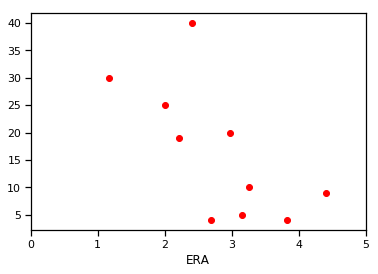

In [3]:
game.plot(x='ERA', y='Points', style='ro', legend=False, xlim=(0,5));

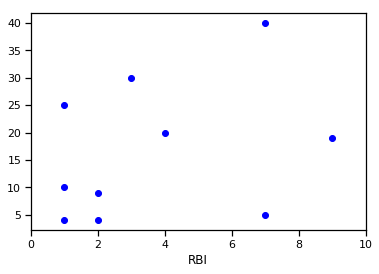

In [4]:
game.plot(x='RBI', y='Points', style='bo', legend=False, xlim=(0,10));

## 1. Linear sum of squares

Let's look at the general linear effect of ERA and RBIs on the game score. Let's build a linear predictive model (a line).

We would like to select $\beta_0, \beta_1$ so that the difference between the predictions and the observations is zero, but this is not usually possible, as with our Vandermonde exercise in our linear algenra introduction notebook. Instead, we choose a reasonable criterion: ***the smallest sum of the squared differences between modelled $\hat{y}$ and observed $y$***.

<div style="font-size: 120%;">  
$$R^2 = \sum_i (y_i - [\beta_0 + \beta_1 x_i])^2 = \sum_i \epsilon_i^2 $$  
</div>

Squaring serves two purposes: 

1. to prevent positive and negative values from cancelling each other out
2. to strongly penalize large deviations. 

Whether or not the latter is a desired depends on the goals of the analysis.

In other words, we will select the parameters that minimize the squared error of the model. Let's write the cost function:

In [5]:
sum_of_squares = lambda θ, x, y: np.sum((y - θ[0] - θ[1]*x) ** 2)

However, we have the stated objective of minimizing the sum of squares, so we can pass this function to one of several optimizers in SciPy:

In [6]:
from scipy.optimize import fmin

x, z, y= game.T.values
x, z, y

(array([1.17, 2.97, 3.26, 2.69, 3.83, 2.  , 4.41, 2.21, 3.15, 2.41]),
 array([3., 4., 1., 1., 2., 1., 2., 9., 7., 7.]),
 array([30., 20., 10.,  4.,  4., 25.,  9., 19.,  5., 40.]))

In [7]:
a0, a1 = fmin(sum_of_squares, [0,1], args=(x,y))
a0, a1

Optimization terminated successfully.
         Current function value: 751.940490
         Iterations: 90
         Function evaluations: 169


(41.542376747358816, -8.876288581138382)

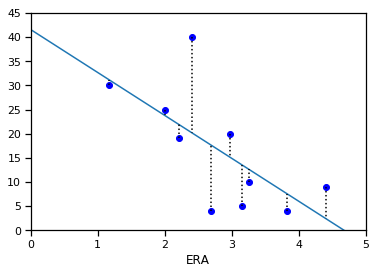

In [8]:
# defense in blue
ax = game.plot(x='ERA', y='Points', style='bo', legend=False, xlim=(0,5), ylim=(0, 45))
ax.plot([0,10], [a0, a0+a1*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, a0+a1*xi], 'k:')

And now for the offense:

In [9]:
b0, b1 = fmin(sum_of_squares, [0,1], args=(z,y))
b0, b1

Optimization terminated successfully.
         Current function value: 1222.353393
         Iterations: 89
         Function evaluations: 170


(11.540297673329285, 1.3674812965595025)

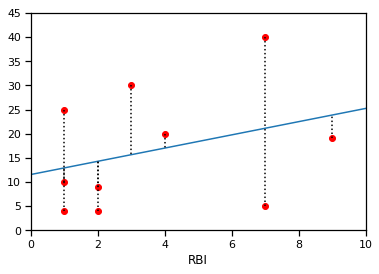

In [10]:
#attack in red
ax = game.plot(x='RBI', y='Points', style='ro', legend=False, xlim=(0,10), ylim=(0, 45))
ax.plot([0,10], [b0, b0+b1*10])
for zi, yi in zip(z,y):
    ax.plot([zi]*2, [yi, b0+b1*zi], 'k:')

As the ability of pitchers on the team improves and the ERA lowers, the score of the team seem to increase faster than with batting prowess of batters on the team (increase in RBIs). Interesting..

<img src="https://breakinggeek.files.wordpress.com/2013/10/calvin-and-hobbes-36dde5a8bd595e00c80689402834d6d363b8b15a-s6-c30.jpg" width=300>

## 2. Bayesian Linear Regression with PyMC3

Let's trun to a Bayesian approach and build a regression model in PyMC3 for the games we just recorded.

### Likelihood

We'll pick a **normal** distribution of game points (game scores) as our model, with a **mean** and **standard deviation** as parameters:

$$y_i \sim \text{Normal}(\mu_i, \sigma)$$

Here, $\mu_i$ is the expected value of the *i*th observation, which is generated by the regression model at the corresponding value of $x$. We calculate this expected value as a function of the regression parameters and the data.

We know that a Points outcome is most often modelled as a **Poisson distribution**, but here we'll use a Normal distribution instead. It may very well not work, the probabilistic computation may fail, your laptop may go up in smoke, but it;s the simplest possible thing we can do..

We score *observed* team strength with a single scalar value: ***Points***. However, the important parameters that will help the coach devise a winning strategy are *latent* (hidden). 

Let's assume one latent parameter $\theta$ as the following linear combination of:
- a constant (the bias)
- the ERA of pitchers
- the RBI of batters

So we write:

$$log(\theta) = \text{intercept} + \text{slope1} * \text{ERA} + \text{slope2} * \text{RBI}$$

We'll incorporate that latent parameter as the mean of the normal distribution model for ***Points***.

Let me stress: It should be a **Poisson distribution** instead (more appropriate for counts). But i'm using a **Normal distribution**, to simplify.

### Priors
The first step in specifying our model is to specify **priors** for our model.

Recall we use a linear model for μ, with an `intercept` (bias) factor and two linear factors `slope1` and `slope2` to represent ERA and RBI:

$$μ = \text{intercept} + \text{slope1}*x + \text{slope2}*z$$
    
We are going to model these factors as normal distributions with a *wide* support: 

$$\sim \text{Normal}(0, 100)$$

and finally the standard deviation of our modelled ***Points*** will be a **half Cauchy**:

$$\sigma \sim \text{HalfCauchy}(1)$$

The half-Cauchy distribution (half of a [Cauchy](https://en.wikipedia.org/wiki/Cauchy_distribution)) has support over positive continuous values, and relatively large tail probabilities, allowing for the possibility of extreme values. It is a very often used modeling pdf.

Since we want to track `slope1` and `slope2`, we need to add them as deterministic variables of our model: `pm.Deterministic`.

Ok, let's get cooking..

In [11]:
from pymc3 import Normal, HalfCauchy, Deterministic, Model

with Model() as game_model:
    
    intercept = Normal('intercept', 0, sd=100)
    slope1 = Normal('slope1', 0, sd=100)
    slope2 = Normal('slope2', 0, sd=100)
    era = Deterministic('era', slope1)
    rbi = Deterministic('rbi', slope2)
    σ = HalfCauchy('σ', 1)

In [12]:
with game_model:
    
    μ = intercept + slope1*x + slope2*z
    score = Normal('score', μ, sd=σ, observed=y)

All right! Now your regression model is fully specified and you are ready to track your posteriors.

You can now use the fitting method of your choice to estimate a posterior distribution. Let's use a **Markov chain Monte Carlo** algorithm, called **NUTS** (the No U-Turn Sampler).

In [13]:
from pymc3 import sample

with game_model:

    game_sample = sample(2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, slope2, slope1, intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:06<00:00, 1553.53draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8959755730661062, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8998128297025633, but should be close to 0.8. Try to increase the number of tuning steps.


Ok.. to be expected.. Does not look very good..

Let's plot posteriors anyway:

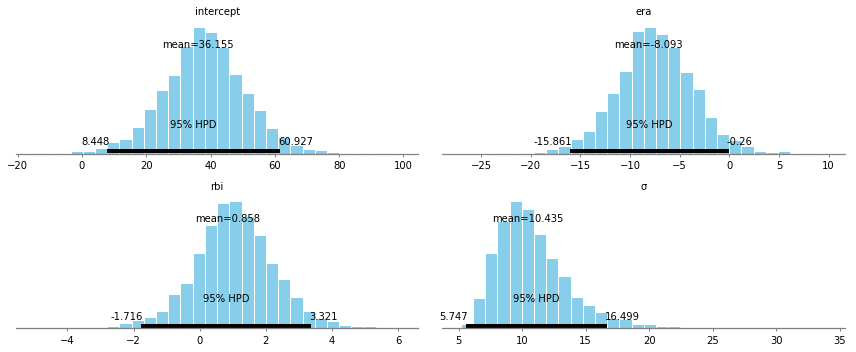

In [14]:
from pymc3 import plot_posterior

plot_posterior(game_sample[500:], varnames=['intercept', 'era', 'rbi', 'σ']);

# Checking model fit

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit the model. In other words, the fitted model can be used to **simulate
data**, and the distribution of the simulated data should resemble the distribution of the actual data.

Sampling from the **posterior predictive distribution** is straighforward in PyMC3. The `sample_ppc` function draws posterior predictive checks from all of the data likelihoods. 

In [15]:
from pymc3 import sample_ppc

with game_model:
    
    game_ppc = sample_ppc(game_sample, 1000)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """
100%|██████████| 1000/1000 [00:01<00:00, 555.67it/s]


This yields 1000 simulated games corresponding to each of the ten data points in our observation vector.

In [16]:
game_ppc['score'].shape

(1000, 10)

We can then compare these simulated data to the data we used to fit the model. 

The model should prove that ***it*** could have been used to generate the game data that we observed.

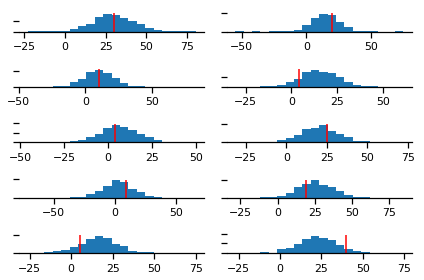

In [17]:
fig, axes = plt.subplots(5, 2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:], y, game_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

#axes_flat[-1].axis('off')
plt.tight_layout()

Ok, I can live with that.

Let's explore:

In [18]:
game_ppc['score'][0]


array([17.2416289 , 22.86756266,  5.40851091, 22.70353034,  7.64005668,
       19.65190607, -0.54642223, 17.4751985 , 19.96288101, 17.49786189])

In [19]:
len(game_sample['σ'])

8000

8000 points because 4 chains of 2000 points each.

The highest posterior density interval (HDI) is the shortest interval on a posterior density for some given confidence level. HDI has the nice property that any point **within** the interval has a higher density than any other point outside. Thus, the HPD interval is **the** collection of most likely values of a parameter.

What is the interval for the likely values for the RBIs?

In [20]:
import pymc3 as pm
pm.stats.hpd(game_sample['rbi'])

array([-1.67295015,  3.32093603])

What is the interval for the likely values for the ERAs?

In [21]:
pm.stats.hpd(game_sample['era'])

array([-16.0346159 ,  -0.15127676])

Quantiles are sets of values of a variate that divide a frequency distribution into equal groups, each containing the same fraction of the total population. The Median for example separates the two halves of a group. So batters below the median RBI *suck*, and those above it are *ok* :-)

In [22]:
pm.stats.quantiles(game_sample['rbi'])

{2.5: -1.672108896034161,
 25: 0.09430720340853929,
 50: 0.8415869425155175,
 75: 1.613630749627029,
 97.5: 3.3390543178177037}

Likewise with the pitchers. These with an ERA less than -8 (-8? How did we get to negative numbers?) *suck*.

In [23]:
pm.stats.quantiles(game_sample['era'])

{2.5: -15.836303037605111,
 25: -10.497689809168495,
 50: -8.1271545815575,
 75: -5.601724094940667,
 97.5: 0.17465801603643677}

Now let's collect our simulated latent parameters from the simulation, and build our theoretical model (which was verified to be "ok") with these parameters. The parameters now drive the score, which is what we want.

Since the score is a normal distribution, we enter its mean and its standard deviation as modelled:

In [24]:
rbis = game_sample['rbi']
eras = game_sample['era']
intercepts = game_sample['intercept']
sig = game_sample['σ']
score_samples = Normal.dist(intercepts + eras + rbis, sig).random()

In [25]:
len(score_samples)

8000

The mean of the RBIs for the simulation is:

In [26]:
rbis.mean()

0.8503461761057864

The mean probability that the team that played the 10 observed games actually wins is above 75%. Pretty good!

In [27]:
(score_samples > 20).mean()

0.7535

Now let's do some experimentation.

<img src="http://www.knowitalljoe.com/wp-content/uploads/2016/01/Star-Wars-Calvin-and-Hobbes-Mashup-1.jpg" width=300>

What happens if we increase the RBIs?

In [28]:
higher_rbis = rbis + 0.10
higher_rbis.mean()

0.9503461761057865

Let's evaluate the new scores based on our model:

In [29]:
new_score_samples = Normal.dist(intercepts + eras + higher_rbis, sig).random()

And what's the probability of winning *now*?

In [30]:
(new_score_samples > 20).mean()

0.758625

Oh... Looks like increase RBIs leads to a better team. Imagine that..

In [31]:
d = {'ERA': eras[7990:],'RBI': rbis[7990:],'Points':score_samples[7990:]}
pd.DataFrame(d)

,ERA,RBI,Points
0,-4.454484,-0.012887,38.949398
1,-7.843039,1.527065,28.801870
2,-6.795969,1.893253,24.857303
3,-3.745422,1.387942,24.802341
4,-9.159520,1.222857,27.303511
5,-11.909719,0.018332,27.191192
6,-10.002674,2.131591,33.281874
7,-5.082089,-0.058308,17.058521
8,-8.491698,0.808145,27.986914
9,-5.958050,0.433329,21.413234


In [32]:
lower_eras = eras - 0.10
lower_eras.mean()

-8.154046654543306

The End.